# 0x04 Multilayer Perceptrons

A Multilayer Perceptron (MLP) is a class of feedforward artificial neural network that consists of at least three layers of nodes: an input layer, one or more hidden layers, and an output layer. These networks form the foundation of deep learning and were one of the earliest neural network architectures.

In this tutorial, we will:
1. Understand the basics of MLPs and their components
2. Implement a simple MLP from scratch
3. Use PyTorch to build and train an MLP
4. Visualize the decision boundaries
5. Compare MLP with other classifiers we've seen

## 1. Understanding MLPs

An MLP is composed of:
- **Input layer**: Receives the input features
- **Hidden layers**: Perform non-linear transformations
- **Output layer**: Produces the final prediction

Each node in a layer is connected to every node in the adjacent layers. This is why MLPs are also called "Fully Connected networks (FC)".

The key components that make MLPs work are:
1. **Weights and biases**: Parameters that are learned during training
2. **Activation functions**: Non-linear functions that introduce complexity to the model
3. **Loss function**: Measures how well the network is performing
4. **Optimization algorithm**: Updates the weights and biases to minimize the loss

The mathematical formula for a single layer in an MLP is:
$$
y = \sigma(Wx + b)
$$

where:
- $x$ is the input vector
- $W$ is the weight matrix
- $b$ is the bias vector
- $\sigma$ is the activation function
- $y$ is the output vector

Let's first import the necessary libraries for our tutorial.

In [772]:
# For visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# For MLP implementation
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

# For comparison
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Set the random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## 2. Dataset and Preprocessing

Just like in the previous tutorial, we'll use the Iris dataset. The Iris dataset contains measurements of three different species of iris flowers: setosa, versicolor, and virginica. Each sample has four features: sepal length, sepal width, petal length, and petal width.

In [773]:
# Import the iris dataset
iris_df = pd.read_csv("data/Iris.csv")

# Display the first few rows
iris_df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


Let's visualize the dataset using sepal length and sepal width as we did before.

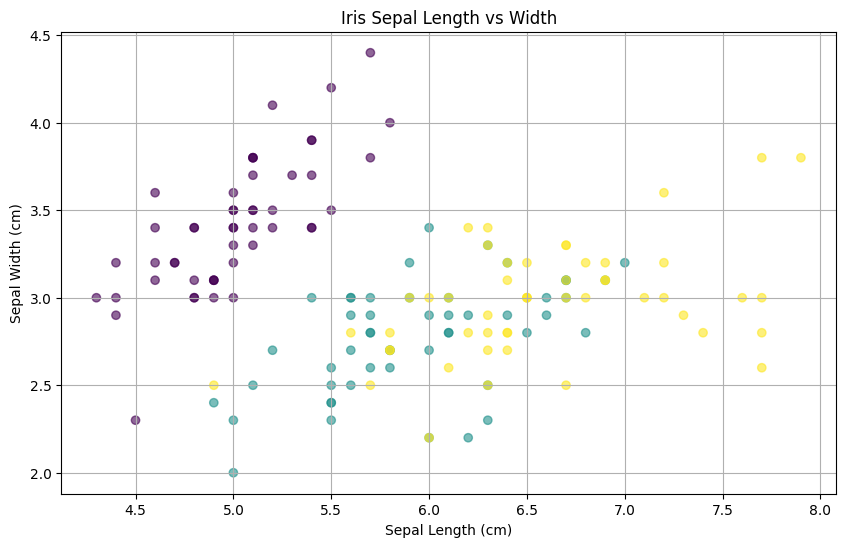

In [774]:
vis_df = iris_df.copy()
vis_df["Species"] = vis_df["Species"].astype("category")

plt.figure(figsize=(10, 6))
plt.scatter(
    vis_df["SepalLengthCm"],
    vis_df["SepalWidthCm"],
    c=vis_df["Species"].cat.codes,
    cmap="viridis",
    alpha=0.6,
)
plt.title("Iris Sepal Length vs Width")
plt.xlabel("Sepal Length (cm)")
plt.ylabel("Sepal Width (cm)")
plt.grid()
plt.show()

Now, let's prepare our data for modeling. We'll use 2 features (sepal length and sepal width) for simplicity. We'll also split the dataset into training and testing sets.

In [775]:
# Split features and target
X = iris_df[["SepalLengthCm", "SepalWidthCm"]]
y = iris_df["Species"]

# Create category codes for the target
species_to_code = {"Iris-setosa": 0, "Iris-versicolor": 1, "Iris-virginica": 2}
y_encoded = y.map(species_to_code)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

> 🤔 **THINKING**
>
> Why do we need to scale the features before training the MLP?
>
> - Neural networks are sensitive to the scale of input features
> - Unscaled features can lead to unstable gradients during training
> - Features with larger scales might dominate the learning process
> - Scaling helps the network converge faster and more reliably

## 3. MLP from Scratch

Before we use PyTorch, let's implement a simple MLP from scratch to understand the mechanics.

In [776]:
class SimpleNeuron:
    def __init__(self, n_inputs):
        # Initialize weights and bias
        self.weights = np.random.randn(n_inputs) * 0.01
        self.bias = 0

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, inputs):
        # Calculate net input
        net_input = np.dot(inputs, self.weights) + self.bias
        # Apply activation function
        output = self.sigmoid(net_input)
        return output

In [777]:
class SimpleMLP:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize layers
        self.hidden_layer = [SimpleNeuron(input_size) for _ in range(hidden_size)]
        self.output_layer = [SimpleNeuron(hidden_size) for _ in range(output_size)]

    def forward(self, X):
        # Forward pass through hidden layer
        hidden_outputs = np.array([neuron.forward(X) for neuron in self.hidden_layer])
        # Forward pass through output layer
        final_outputs = np.array(
            [neuron.forward(hidden_outputs) for neuron in self.output_layer]
        )
        return final_outputs

This is a very simplified MLP without backpropagation or training capability. It will just do a forward pass with random weights.

In [778]:
# Create a simple MLP with 2 inputs, 5 hidden neurons, and 3 output neurons
simple_mlp = SimpleMLP(2, 5, 3)

# Test with a single sample
sample = X_train_scaled[0]
print("Input:", sample)
print("Output:", simple_mlp.forward(sample))

Input: [-1.47393679  1.22037928]
Output: [0.49459559 0.49551712 0.49917112]


> 📝 **OBSERVATION**
>
> Our simple MLP produces outputs between 0 and 1 due to the sigmoid activation function.
> However, the outputs are random because we haven't trained the network.
> A complete implementation would include backpropagation and weight updates.

## 4. MLP with PyTorch

Now, let's implement an MLP using PyTorch, which provides us with the necessary tools for both defining the network architecture and training it effectively.

In [779]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        # Define layers
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)

        # Define activation functions
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Forward pass through the network
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.hidden_layer(x)
        x = self.relu(x)
        x = self.output_layer(x)
        x = self.softmax(x)
        return x

Now let's set up the training loop.

In [780]:
# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test.values)

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Define model, loss function, and optimizer
input_size = X_train_scaled.shape[1]  # Number of features (2 in this case)
hidden_size = 10
output_size = 3  # Number of classes

model = MLP(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

> 🤔 **THINKING**
>
> - Why do we use ReLU activation for the hidden layers but Softmax for the output layer?
> - How does the choice of activation function affect the network's ability to learn?
> - What would happen if we used a different optimizer like SGD instead of Adam?

Let's train the model!

In [781]:
# Training loop
epochs = 100
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    avg_loss = running_loss / len(train_loader.dataset)  # type: ignore
    train_losses.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 10/100, Loss: 0.7983
Epoch 20/100, Loss: 0.7622
Epoch 30/100, Loss: 0.7524
Epoch 40/100, Loss: 0.7443
Epoch 50/100, Loss: 0.7390
Epoch 60/100, Loss: 0.7346
Epoch 70/100, Loss: 0.7361
Epoch 80/100, Loss: 0.7336
Epoch 90/100, Loss: 0.7313
Epoch 100/100, Loss: 0.7315


Let's visualize the training loss to see how our model is learning.

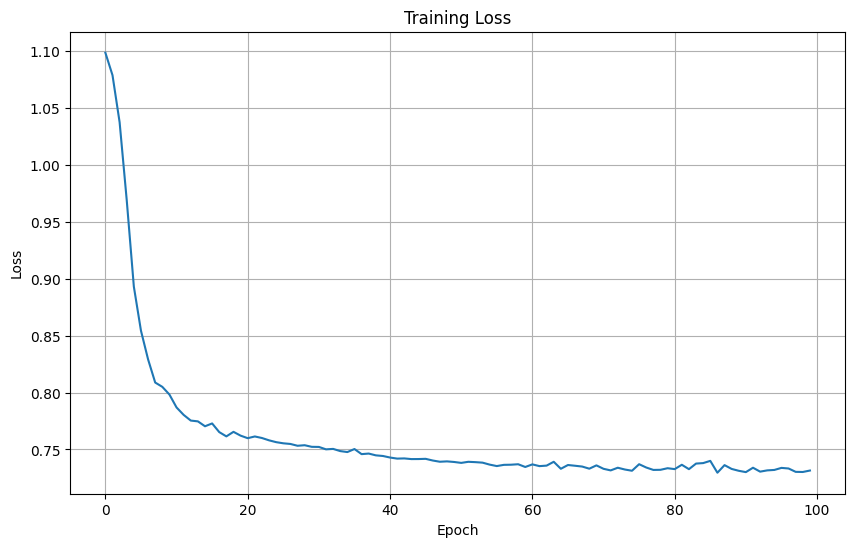

In [782]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

Now, let's evaluate our model on the test set.

Test Accuracy: 0.9000


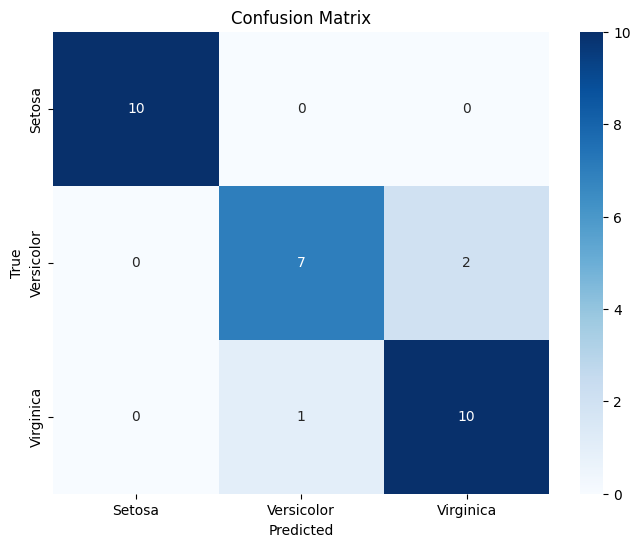

In [783]:
# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = accuracy_score(y_test, predicted.numpy())
    print(f"Test Accuracy: {accuracy:.4f}")

    # Plot the confusion matrix
    conf_matrix = confusion_matrix(y_test, predicted.numpy())
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Setosa", "Versicolor", "Virginica"],
        yticklabels=["Setosa", "Versicolor", "Virginica"],
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

## 5. Visualizing the Decision Boundary

Let's visualize the decision boundary of our MLP model using the first two features (sepal length and sepal width).

In [784]:
# Create a meshgrid for visualization
X_vis = iris_df[["SepalLengthCm", "SepalWidthCm"]].values
x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

Since our MLP was trained on four features, we need to set the other two features to their mean values.

In [785]:
# Create a 2D array of points in the feature space
mesh_points = pd.DataFrame(
    {"SepalLengthCm": xx.reshape(-1), "SepalWidthCm": yy.reshape(-1)}
)

# Scale the mesh points
mesh_points_scaled = scaler.transform(mesh_points)

# Make predictions on the mesh grid points
model.eval()
with torch.no_grad():
    mesh_tensor = torch.FloatTensor(mesh_points_scaled)
    mesh_outputs = model(mesh_tensor)
    _, mesh_preds = torch.max(mesh_outputs, 1)
    Z = mesh_preds.numpy().reshape(xx.shape)

Now let's plot the decision boundary.

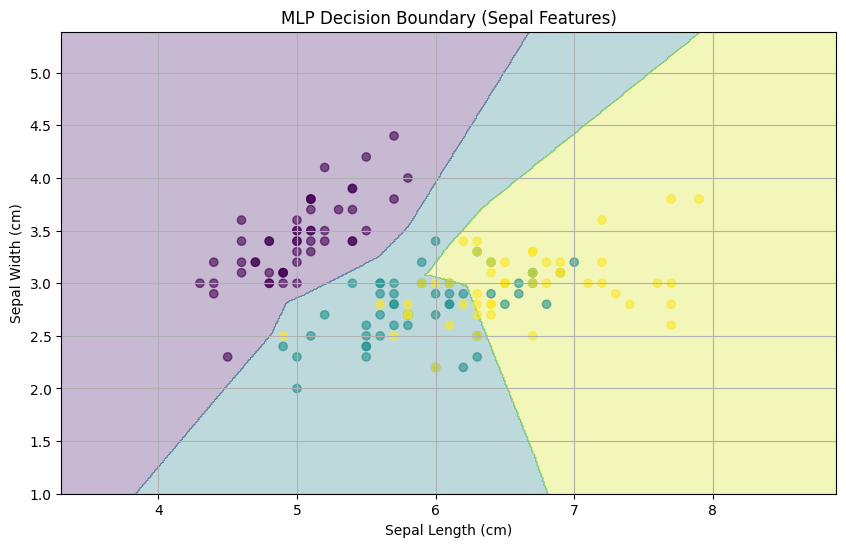

In [786]:
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap="viridis")
plt.scatter(
    vis_df["SepalLengthCm"],
    vis_df["SepalWidthCm"],
    c=vis_df["Species"].cat.codes,
    cmap="viridis",
    alpha=0.6,
)
plt.title("MLP Decision Boundary (Sepal Features)")
plt.xlabel("Sepal Length (cm)")
plt.ylabel("Sepal Width (cm)")
plt.grid()
plt.show()

> 📝 **OBSERVATION**
>
> The decision boundary of the MLP can be quite complex, as it can learn non-linear relationships.
> This is a significant advantage of MLPs over linear classifiers, which can only learn linear decision boundaries.

## 6. Comparison with Other Classifiers

Let's compare our MLP with other classifiers we've seen before: Logistic Regression and Naive Bayes.

In [787]:
# Train Logistic Regression
lr = LogisticRegression(max_iter=200)
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
lr_accuracy = accuracy_score(y_test, lr_pred)

# Train Naive Bayes
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
nb_pred = nb.predict(X_test_scaled)
nb_accuracy = accuracy_score(y_test, nb_pred)

# Our PyTorch MLP
pytorch_mlp_accuracy = accuracy

# Compare accuracies
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")
print(f"PyTorch MLP Accuracy: {pytorch_mlp_accuracy:.4f}")

Logistic Regression Accuracy: 0.9000
Naive Bayes Accuracy: 0.9000
PyTorch MLP Accuracy: 0.9000


Let's visualize the decision boundaries of all three classifiers together.

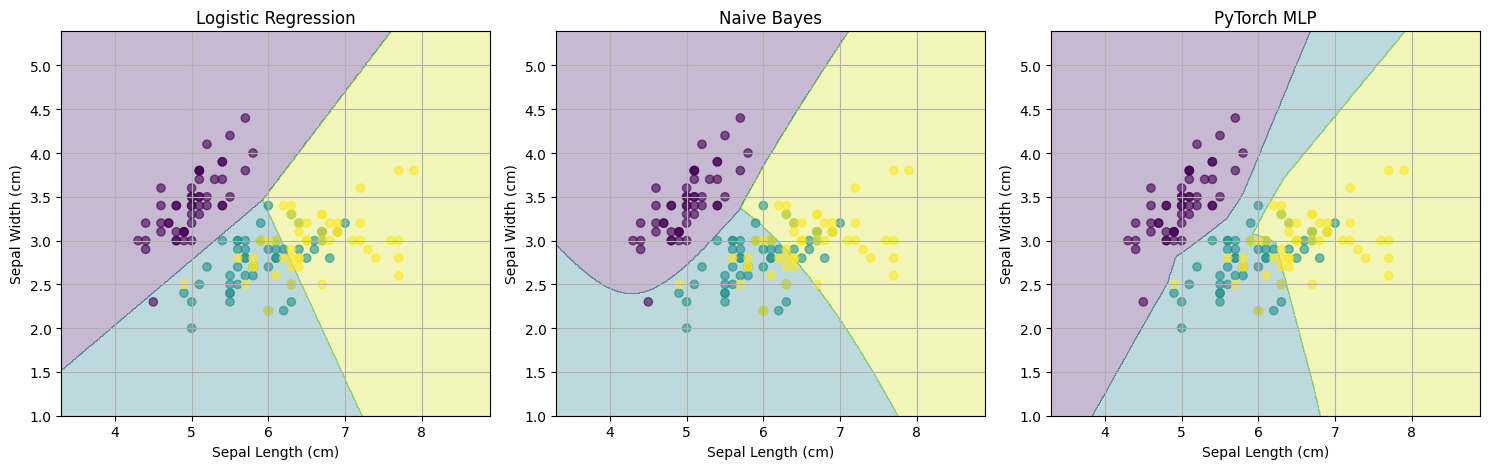

In [788]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


# Helper function to plot decision boundaries
def plot_decision_boundary(ax, classifier, title, is_torch_model=False):
    # Create a meshgrid for visualization
    X_vis = iris_df[["SepalLengthCm", "SepalWidthCm"]].values
    x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
    y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    # Create a 2D array of points in the feature space
    mesh_points = pd.DataFrame(
        {"SepalLengthCm": xx.reshape(-1), "SepalWidthCm": yy.reshape(-1)}
    )
    mesh_points_scaled = scaler.transform(mesh_points)
    # Make predictions on the mesh grid points
    if is_torch_model:
        with torch.no_grad():
            mesh_tensor = torch.FloatTensor(mesh_points_scaled)
            mesh_outputs = classifier(mesh_tensor)
            _, mesh_preds = torch.max(mesh_outputs, 1)
            Z = mesh_preds.numpy().reshape(xx.shape)
    else:
        Z = classifier.predict(mesh_points_scaled).reshape(xx.shape)

    # Plot the decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap="viridis")
    ax.scatter(
        vis_df["SepalLengthCm"],
        vis_df["SepalWidthCm"],
        c=vis_df["Species"].cat.codes,
        cmap="viridis",
        alpha=0.6,
    )
    ax.set_title(title)
    ax.set_xlabel("Sepal Length (cm)")
    ax.set_ylabel("Sepal Width (cm)")
    ax.grid()


# Plot decision boundaries
plot_decision_boundary(axes[0], lr, "Logistic Regression")
plot_decision_boundary(axes[1], nb, "Naive Bayes")
plot_decision_boundary(axes[2], model, "PyTorch MLP", is_torch_model=True)

plt.tight_layout(rect=(0, 0, 1, 0.96))
plt.show()

> 🤔 **THINKING**
>
> - How do the decision boundaries differ between the classifiers?
> - Why might MLP perform better or worse than the other classifiers on this dataset?
> - What advantages do MLPs have over simpler models?
> - What are the trade-offs when using MLPs?

## 7. Understanding Neurons and Weights

Let's visualize the weights learned by our MLP's first layer. Each neuron in the first hidden layer has weights connecting it to each input feature.

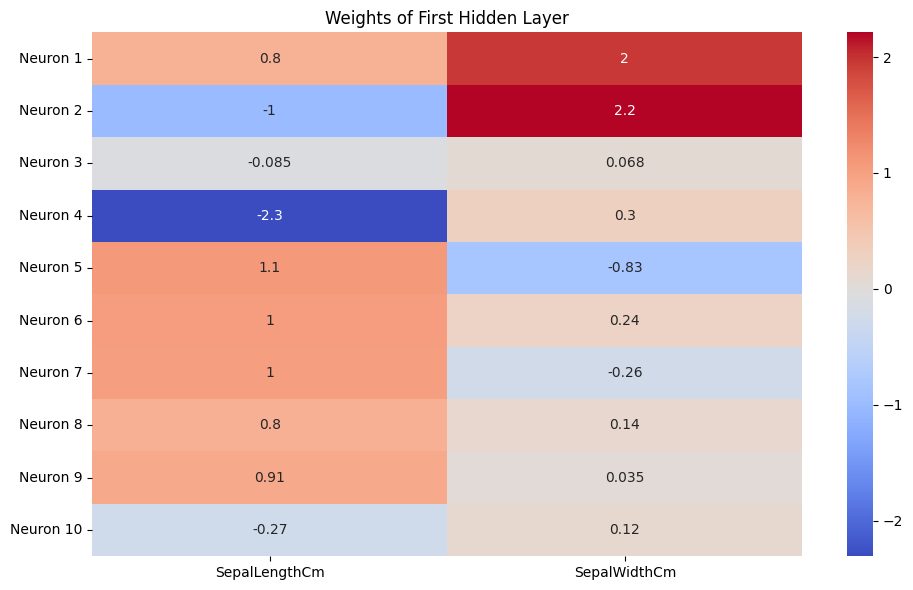

In [789]:
# Extract weights from the first layer
weights = model.input_layer.weight.data.numpy()

# Create a heatmap of the weights
plt.figure(figsize=(10, 6))
sns.heatmap(
    weights,
    annot=True,
    cmap="coolwarm",
    xticklabels=X.columns.tolist(),
    yticklabels=[f"Neuron {i + 1}" for i in range(hidden_size)],
)
plt.title("Weights of First Hidden Layer")
plt.tight_layout()
plt.show()

> 📝 **OBSERVATION**
>
> The heatmap shows the learned weights for each connection between the input features and the neurons in the first hidden layer.
> - Positive weights (red) indicate positive correlations
> - Negative weights (blue) indicate negative correlations
> - The intensity of the color represents the magnitude of the weight

## 8. Activation Function Visualization

Let's visualize the common activation functions used in MLPs to understand their behavior.

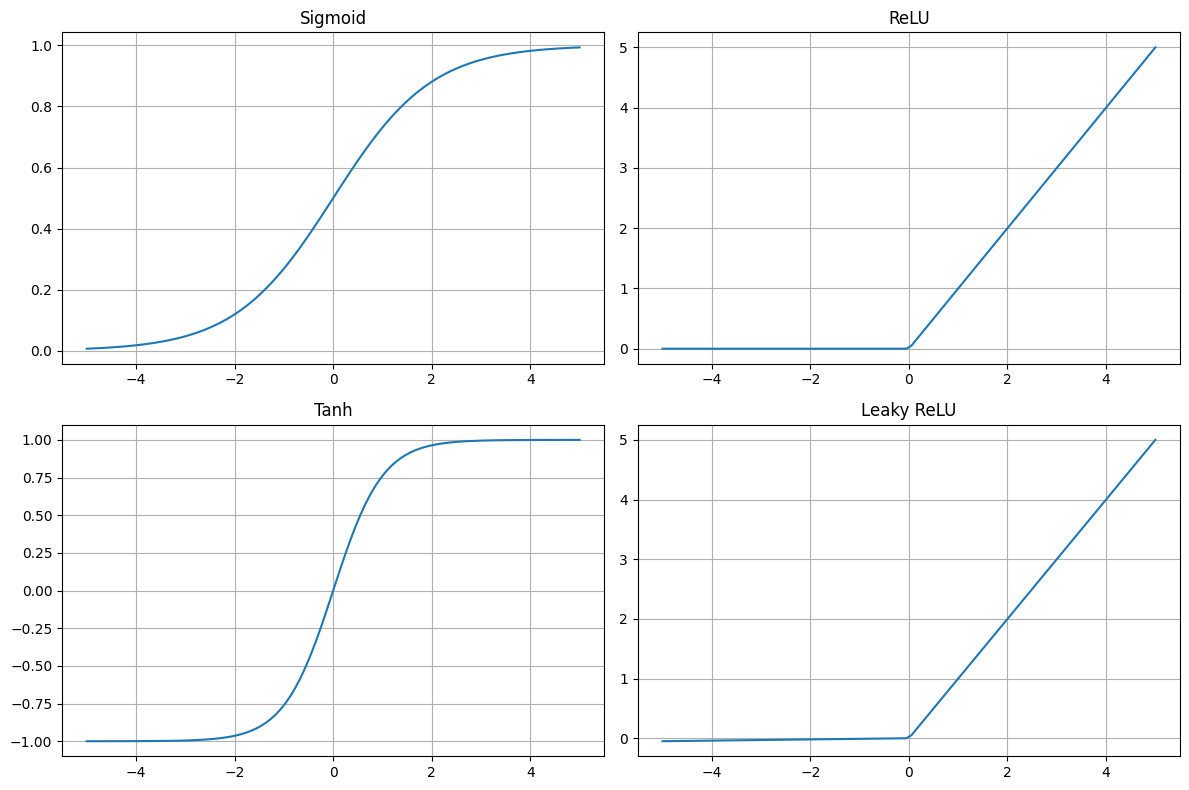

In [790]:
# Define activation functions


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def relu(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)


def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)


# Create input values
x = np.linspace(-5, 5, 100)

# Plot activation functions
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(x, sigmoid(x))
plt.title("Sigmoid")
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(x, relu(x))
plt.title("ReLU")
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(x, tanh(x))
plt.title("Tanh")
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(x, leaky_relu(x))
plt.title("Leaky ReLU")
plt.grid()

plt.tight_layout()
plt.show()

> 🤔 **THINKING**
>
> - How do different activation functions affect the learning ability of the network?
> - Why is ReLU often preferred over sigmoid or tanh in hidden layers?
> - What problems can arise with ReLU, and how does Leaky ReLU address them?

## 9. Neural Network Interpretation

One of the challenges with neural networks is their interpretability. Let's try to understand what our MLP has learned by examining the activations of hidden neurons for different inputs.

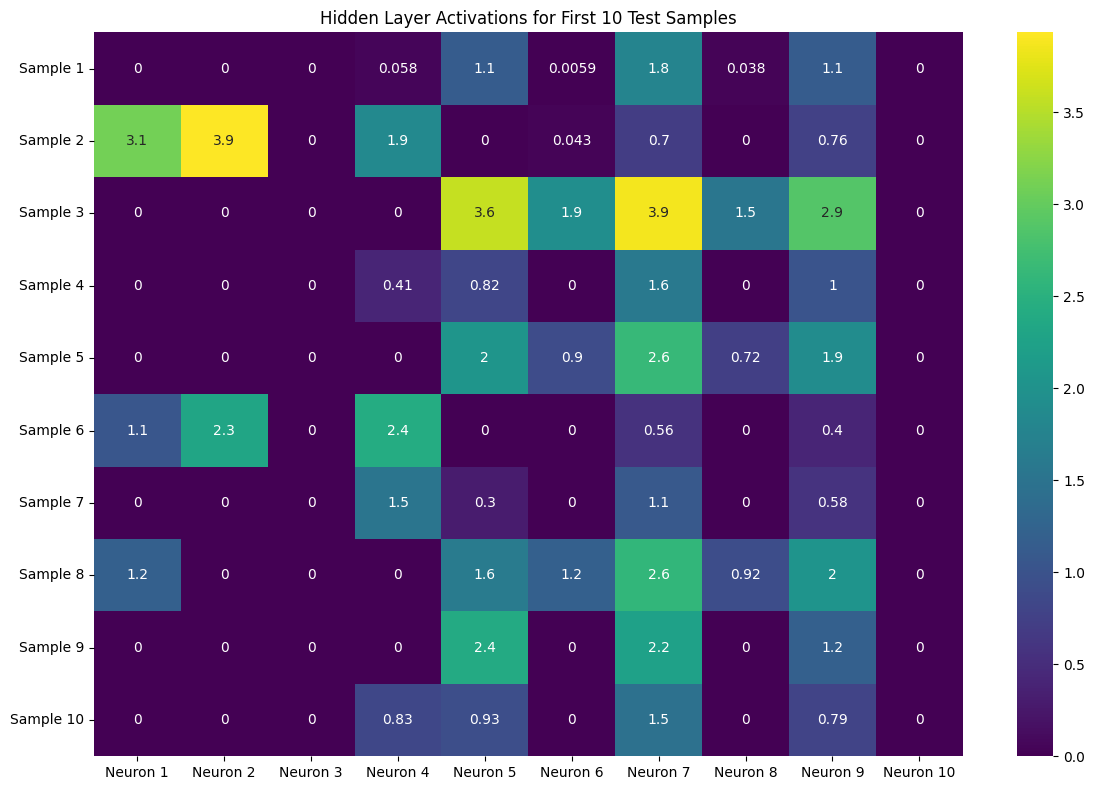

In [791]:
def get_hidden_activations(model, inputs):
    # Get activations of the first hidden layer
    activations = model.relu(model.input_layer(inputs)).detach().numpy()
    return activations


# Get activations for the test set
hidden_activations = get_hidden_activations(model, X_test_tensor)

# Create a heatmap of the activations
plt.figure(figsize=(12, 8))
sns.heatmap(
    hidden_activations[:10],
    annot=True,
    cmap="viridis",
    xticklabels=[f"Neuron {i + 1}" for i in range(hidden_size)],
    yticklabels=[f"Sample {i + 1}" for i in range(10)],
)
plt.title("Hidden Layer Activations for First 10 Test Samples")
plt.tight_layout()
plt.show()

Let's also visualize the average activation of each neuron for each class.

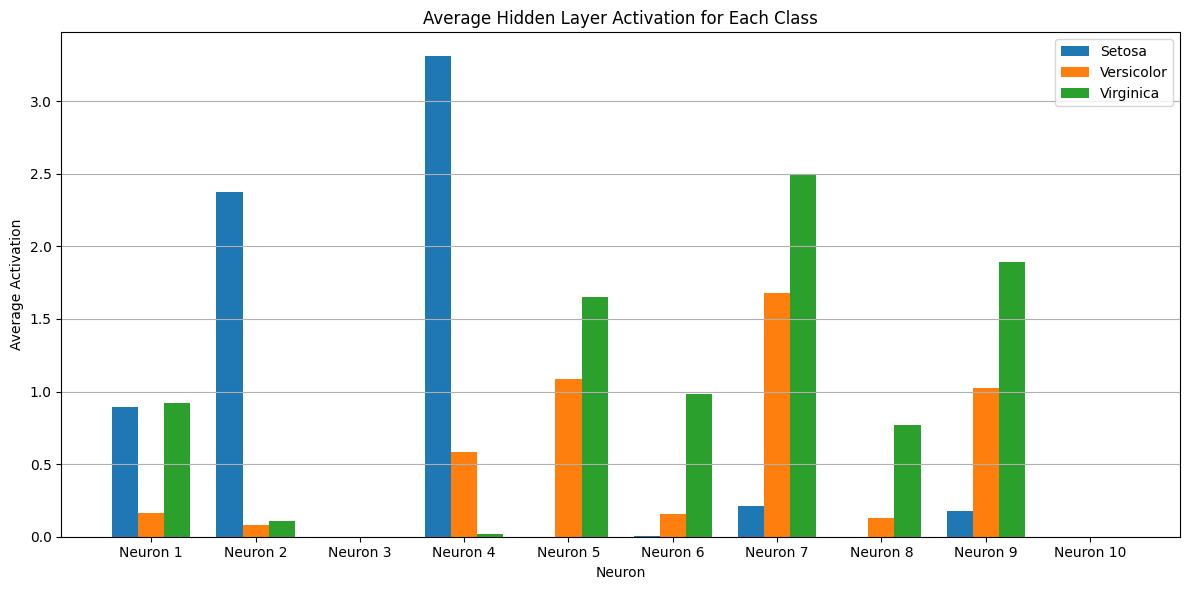

In [792]:
# Get class labels for the test set
test_labels = y_test.values

# Calculate average activations per class
class_activations = {}
for class_idx in range(3):
    class_mask = test_labels == class_idx
    class_activations[class_idx] = hidden_activations[class_mask].mean(axis=0)

# Create a bar chart of average activations
plt.figure(figsize=(12, 6))
bar_positions = np.arange(hidden_size)
width = 0.25

plt.bar(bar_positions - width, class_activations[0], width, label="Setosa")
plt.bar(bar_positions, class_activations[1], width, label="Versicolor")
plt.bar(bar_positions + width, class_activations[2], width, label="Virginica")

plt.xlabel("Neuron")
plt.ylabel("Average Activation")
plt.title("Average Hidden Layer Activation for Each Class")
plt.xticks(bar_positions, [f"Neuron {i + 1}" for i in range(hidden_size)])
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()

> 📝 **OBSERVATION**
>
> Different neurons in the hidden layer activate differently for different classes.
> Some neurons seem to be more important for certain classes, which means they have learned to recognize specific patterns in the data.
> This visualization helps us understand what the network has learned, even if the exact interpretation remains complex.

## 10. Effect of Hyperparameters

Let's investigate how changing the hyperparameters affects the performance of our MLP.

In [793]:
def train_and_evaluate_mlp(hidden_size, learning_rate, epochs):
    # Create model
    model = MLP(input_size, hidden_size, output_size)

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    train_losses = []

    for _epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        _, predicted = torch.max(test_outputs, 1)
        accuracy = accuracy_score(y_test, predicted.numpy())

    return model, train_losses, accuracy

Let's test different hidden layer sizes.

In [794]:
hidden_sizes = [5, 10, 20, 50]
learning_rate = 0.01
epochs = 100

results = []

for size in hidden_sizes:
    model, losses, accuracy = train_and_evaluate_mlp(size, learning_rate, epochs)
    results.append({"hidden_size": size, "losses": losses, "accuracy": accuracy})
    print(f"Hidden Size: {size}, Accuracy: {accuracy:.4f}")

Hidden Size: 5, Accuracy: 0.8667
Hidden Size: 10, Accuracy: 0.8667
Hidden Size: 20, Accuracy: 0.8333
Hidden Size: 50, Accuracy: 0.8000


Let's plot the training loss for different hidden layer sizes.

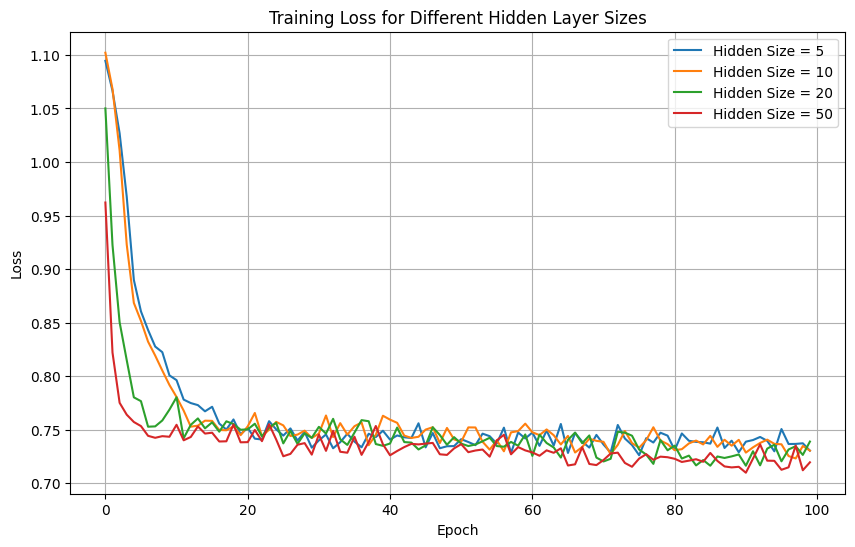

In [795]:
plt.figure(figsize=(10, 6))
for result in results:
    plt.plot(result["losses"], label=f"Hidden Size = {result['hidden_size']}")

plt.title("Training Loss for Different Hidden Layer Sizes")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

Now let's plot the test accuracy for different hidden layer sizes.

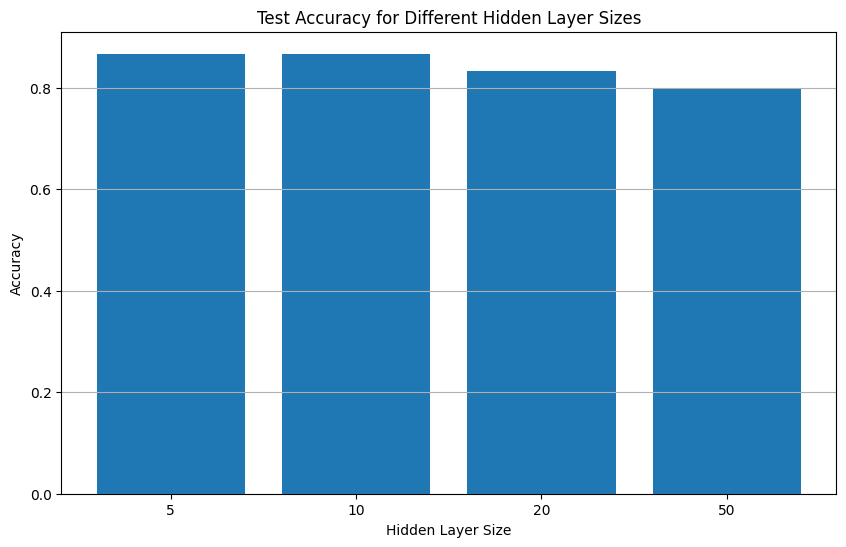

In [796]:
plt.figure(figsize=(10, 6))
hidden_sizes_labels = [str(result["hidden_size"]) for result in results]
accuracies = [result["accuracy"] for result in results]

plt.bar(range(len(hidden_sizes)), accuracies)
plt.xticks(range(len(hidden_sizes)), hidden_sizes_labels)
plt.title("Test Accuracy for Different Hidden Layer Sizes")
plt.xlabel("Hidden Layer Size")
plt.ylabel("Accuracy")
plt.grid(axis="y")
plt.show()

> 📚 **EXERCISE**
>
> Now it's your turn to experiment with different hyperparameters:
>
> 1. Try different learning rates (e.g., 0.001, 0.01, 0.1) and observe the impact on training losses and accuracy.
> 2. Modify the MLP architecture by adding more hidden layers. Compare the performance of models with one vs. two hidden layers.
> 3. Try different activation functions (e.g., Tanh, Leaky ReLU) and observe their impact on performance.
> 4. Experiment with different batch sizes during training.
> 5. Implement early stopping to prevent overfitting.

## 11. Conclusion

In this tutorial, we explored Multilayer Perceptrons, one of the fundamental neural network architectures. We:

1. Implemented a simple MLP from scratch to understand the basic components
2. Used PyTorch to build and train a more sophisticated MLP
3. Visualized the decision boundaries and compared them with other classifiers
4. Explored the effect of different hyperparameters on performance
5. Attempted to interpret what the neural network has learned

MLPs provide more flexible decision boundaries than linear classifiers like Logistic Regression, which makes them suitable for complex problems. However, they require careful tuning of hyperparameters and can be prone to overfitting if not properly regularized.

The main advantages of MLPs include:
- Ability to learn non-linear relationships
- Flexibility to model complex patterns
- Scalability to high-dimensional data

The main disadvantages include:
- Difficulty in interpretation
- Sensitivity to hyperparameters
- Potential for overfitting
- Need for large amounts of data for optimal performance

> 📚 **EXERCISE**
>
> As a final exercise, try to implement the following:
>
> 1. Add dropout regularization to the MLP to prevent overfitting.
> 2. Use k-fold cross-validation to get a more robust estimate of the model's performance.
> 3. Implement a function to visualize the decision boundary in 3D using three features.
> 4. Try applying the MLP to a different dataset (e.g., wine, digits, breast cancer) and compare its performance to other classifiers.# > 4. Try applying the MLP to a different dataset (e.g., wine, digits, breast cancer) and compare its performance to other classifiers.# > 4. Try applying the MLP to a different dataset (e.g., wine, digits, breast cancer) and compare its performance to other classifiers.